In [1]:
import sys
sys.path.append("/home/bl9/gempy/")
#sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

from gempy import Topology

import vtk

from scipy.interpolate import griddata

In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,-2000,0],[ 50,50,50],
                         #path_f = "./input_data/Fab_TrapModel_Foliations.csv",
                         #path_i = "./input_data/Fab_TrapModel_Points.csv")
                         #path_f = "./input_data/FabLessPoints_Foliations.csv",
                         #path_i = "./input_data/FabLessPoints_Points1.csv")
                         path_f = "./input_data/Fab_Test_Foliations.csv",
                         path_i = "./input_data/Fab_Test_Points.csv")
geo_data.n_faults = 1

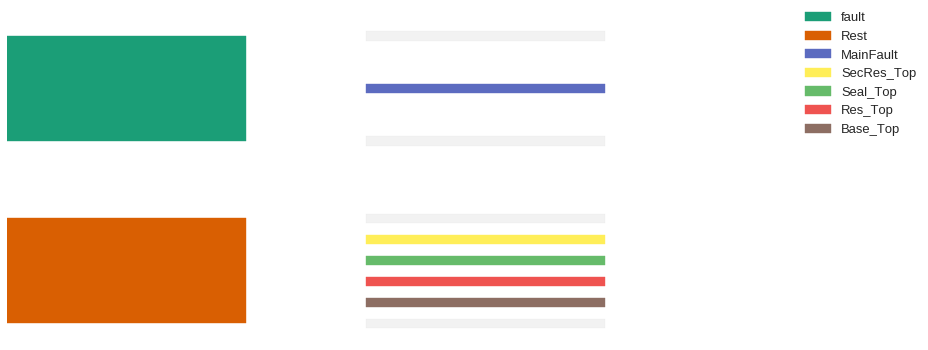

In [3]:
#gp.set_series(geo_data, {"fault":'MainFault', 
#                      "Rest":('Res_Base', 'Res_Top', 'Seal_Top', 'SecondaryReservoir')},
#                       order_series = ["fault","Rest",], order_formations=['MainFault', 
#                                         'SecondaryReservoir', 'Seal_Top', 'Res_Top','Res_Base',
#                                         ]) # for Fab_TrapModel
#
#gp.set_series(geo_data, {"fault":'MainFault', 
#                      "Rest":('Reservoir', 'Seal', 'SecondaryReservoir', 'Overlying')},
#                       order_series = ["fault","Rest",], order_formations=['MainFault', 
#                                         'Overlying', 'SecondaryReservoir', 'Seal','Reservoir',
# #                                        ]) 'for FabLessPoints

gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ]) #for Fab_Test

In [4]:
#geo_data.set_formation_number(['MainFault','Res_Base', 'Res_Top', 'Seal_Top', 'SecondaryReservoir'])

In [5]:
#gp.data_to_pickle(geo_data, 'BasicFault') #saving data to pickle

In [112]:
#geo_data.interfaces.head()
#gp.get_data(geo_data)

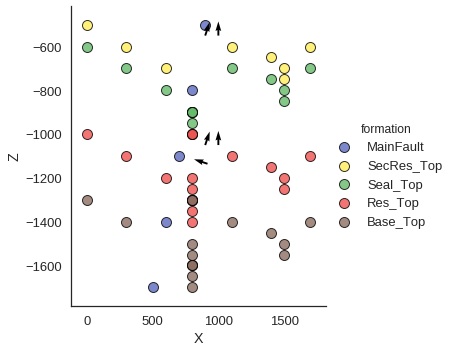

In [4]:
gp.plot_data(geo_data)

In [521]:
gp.plot_data_3D(geo_data)

In [5]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [6]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.3798413800447662e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


In [7]:
# CREATING SURFACES FOR LAYERS
base_surf, base_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Base_Top']))
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Res_Top']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['Seal_Top']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[0,1], potential_fault=fault_sol[0,1], n_formation = (interp_data.get_formation_number()['SecRes_Top']))

In [111]:
#geo_data.get_formation_number().keys()

In [29]:
#geo_data.get_formations()

In [465]:
geo_data.get_formation_number()

{'Base_Top': 5,
 'DefaultBasement': 0,
 'MainFault': 1,
 'Res_Top': 4,
 'Seal_Top': 3,
 'SecRes_Top': 2}

In [16]:
gp.plot_surfaces_3D(geo_data, [base_surf, sec_res_surf, seal_surf, res_surf], 
                    [base_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=True)

In [174]:
gp.plot_surfaces_3D(geo_data, [res_surf], [res_surf_simp])

In [466]:
interp_data.get_formation_number()

{'Base_Top': 5,
 'DefaultBasement': 0,
 'MainFault': 1,
 'Res_Top': 4,
 'Seal_Top': 3,
 'SecRes_Top': 2}

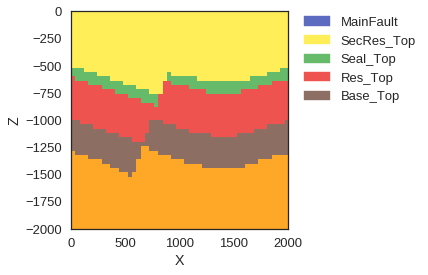

In [8]:
#%matplotlib notebook
%matplotlib inline
gp.plot_section(geo_data, lith_sol[0,0], 25, plot_data=0)

In [9]:
resolution = 50
model_size = 2000
scale_factor = (model_size/resolution) #original grid in [m]/grid resolution --> what if model not cubic?

minmax_buffer = False # buffer around local min and max values [on/off]

In [10]:

def spill_leak_P(interp_data, res_surf):    
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.grid[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.grid[:, 1]))

    grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    rel_order = 2
    
    #check grid_z0 for max and min in directions x and y
    #direction x
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1
    
    #direction y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1
    
    # minmax buffering
    if minmax_buffer:
        grid_minX = np.logical_or(grid_minX,np.roll(grid_minX,1))
        grid_minX = np.logical_or(grid_minX,np.roll(grid_minX,-1))
        grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    
    
    # fault leak line
    # check for minima line that is on footwall side compared to max contact of layer with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold
        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # 15 chosen as threshold --> better method?
    
    #fleak_line_z0 = grid_z0[fleak_line]
    #leak_max = fleak_line==np.nanargmax(fleak_line_z0)
    #print(np.nanargmax(fleak_line_z0))
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?!
    
    # distinguish anticlinal spill points from fault leak points:
    pot_leak_point = np.logical_and(fleak_line,saddle_p_all)
    
    spill_points = saddle_p_all - pot_leak_point
    
    # leak and spill point 3D coordinates
    # LEAK POINT
    pot_leak_Xcoord = grid_x[pot_leak_point]
    pot_leak_Ycoord = grid_y[pot_leak_point]
    pot_leak_Zcoord = grid_z0[pot_leak_point]
    
    pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
    
    if pot_leak_3Dcoord.size == 0:
        fault_leak_3Dcoord = np.array([])
    else:
        max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
        fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:]
        
    # SPILL POINT
    pot_spill_Xcoord = grid_x[spill_points]
    pot_spill_Ycoord = grid_y[spill_points]
    pot_spill_Zcoord = grid_z0[spill_points]
    
    pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
    
    if pot_spill_3Dcoord.size == 0:
        anticline_spill_3Dcoord = np.array([])
    else:
        max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
        anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:]   
        
    #print('SP',anticline_spill_3Dcoord)
    #print('LP',fault_leak_3Dcoord)
    if True:
        figsize(15,6)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, spill_points, c="black", alpha = 1, marker='x', s = 250)
        #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
        #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
    
    plot_spill_leak(res_surf, spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
    
    return anticline_spill_3Dcoord, fault_leak_3Dcoord

In [11]:
# MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = bottom_z/scale_factor
    mask = mask.reshape(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(125000,)
    return mask

# Function that sets all voxels of lith_block which are equal (or closest to) to the spill_z
# horizontal as belonging to the overlying seal 
# (the voxels is located on the border of reservoir and seal):
def set_spill_to_seal(geo_data, lith, max_z):
    lith_spill = np.argmin(np.abs(geo_data.grid.grid[:, 2]+np.abs(max_z)))
    bol_lith_spill = geo_data.grid.grid[:, 2] == geo_data.grid.grid[:, 2][lith_spill]
    lith[bol_lith_spill] = 6
    return lith
        ### Hpw to check in here, if single spill voxel = reservoir (5)??? Need x and y pos?

# Masking that confines the volume to ONLY those reservoir traps (from res_mask)
# that are NOT connected to the borders of the model (open system)
# Traps defined as CLOSED systems
def topo_analysis(lith, fault):
    fig = plt.figure()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(50,50,50), 1, 'constant', constant_values = (8,8)))
    topo = Topology.Topology(lith_pad, fault_pad)
    #topo.draw_section(25)
    topo_block = topo.labels
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    topo_keys = [int(k) for k in topo.lith_to_labels_lot["7"].keys()]
    pad_keys = [int(p) for p in topo.lith_to_labels_lot["8"].keys()]
    #over_keys = [int(o) for o in topo.lith_to_labels_lot["2"].keys()]
    #sec_res_keys = [int(sr) for sr in topo.lith_to_labels_lot["3"].keys()]
    bool_block = np.zeros_like(topo_block)
    # Check for each possible trap section, if it is connected to a border
    for tk in topo_keys:
        print('Checking Section:', tk)
        # Saving enclosed sections as traps
        if topo.check_adjacency(tk, pad_keys[0]) == False:
            print("TRAP FOUND, section:", tk)
            traps.append(tk)
    if traps == []:
        print('No trap found! =(')
    else:
        for i in traps:
            # Creating a mask from the trap sections in the label block
            top_bool = topo_block == i
            bool_block[top_bool] = True
            ### Extra check for juxtaposition with layers above seal
            #if topo.check_adjacency(i, over_keys[0]) == False and topo.check_adjacency(i, sec_res_keys[0]) == False:
            #    print('Trap sealed upwards.')
            #    top_bool = topo_block == i
            #    bool_block[top_bool] = True
            #else: 
            #    print("Juxtaposition, no trap sealing.")
    # Removing padding
    trap_mask = bool_block[1:-1,1:-1,1:-1]
    #plt.imshow(trap_mask[:,25,:].T, origin="lower")
    #plt.show()
    return trap_mask

In [12]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, fault_sealing):
    # calculate spill point
    spill_point, leak_point = spill_leak_P(interp_data, res_surface)
    if spill_point.size == 0:
        spill_z = -2000
        print('No SPILL POINT found!')
    else:
        print('SPILL POINT:',spill_point)
        spill_z = spill_point[2]
    #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
    # calculate leak point
    if leak_point.size == 0:
        print('No LEAK POINT found!')
        leak_z = -2000
    else:
        print('Leak Point:',leak_point)
        leak_z = leak_point[2]
    #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
    bottom_surface = np.ones_like(res_surface)
    
    #PLOTTING OF SPILL, LEAK AND BOTTOM POSSIBLE HERE:
    #plot_spill(res_surface, spill_min_line, spill_p)
    #plot_leak(res_surface, leak_line, leak_p)
    #plot_trap(res_surface, bottom_surface, spill_p, leak_p)
    #PRINTING OF SPILL, LEAK:
    #print('Spill_Z:', spill_z)
    #print('Leak_Z:', leak_z)
    
    # Check for "down-to" z-horizon, maximum depth of reservoir
    # Check for fault sealing and subsequent relevance of leak point
    max_z = np.max([spill_z, leak_z])
    if fault_sealing == True:
        if max_z == spill_z:
            print("Spill point defines trap.")
            print("Fault is sealing. Down to spill.")
            #bottom_surface = spill_bottom
        else:
            print("Fault leak point above spill point.")
            max_z = spill_z
            print("...but fault sealing. Down to spill.")
            #bottom_surface = spill_bottom
    else:
        if max_z == spill_z:
            print("Spill point defines trap.")
            print("Fault is pathway. Down to spill.")
            #bottom_surface = spill_bottom
        else:
            print("Fault leak point above spill point.")
            print("Cross-fault leakage. Down to leak.")
            #bottom_surface = leak_bottom      
    
    #print('Max_Z:', max_z)
    
    res_nr = lith == interp_data.get_formation_number()['Base_Top']
    pre_trap_mask = res_mask(lith, fault, max_z, res_nr)
          
    # volume cells for counting
    vol_cells = 0      
    
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anaything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        print("No res_formation above max_z!")
        return 0, lith, bottom_surface, pre_trap_mask
    else:
        lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
                                                            # (incl. outside trap) to formation value = 7  
        if max_z == spill_z:
            lith = set_spill_to_seal(geo_data, lith, max_z)
        
        #test = lith.reshape(125000)                       
        #for i in range(len(test)):                         #to test pre-trap-masking volume
        #    if test[i] == 7:
        #        vol_cells +=1
        #res_vol = ((scale_factor)**3) * vol_cells 
        #print("VOLUME INCLUDING OUTSIDE TRAP:" ,res_vol)
        
        final_trap_mask = topo_analysis(lith, fault)
        #lith[pre_trap_mask_bool] = 5
        lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
        vol_cells = np.count_nonzero(final_trap_mask)
        
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        
        #return the maximum reservoir volume
        return trap_vol, lith, bottom_surface, final_trap_mask

In [13]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

#def plot_spill(res_surface, spill_min_line, spill_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-spill_min_line[:,0], -spill_min_line[:,1], spill_min_line[:,2], c='r', s = 50)
#    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 200)
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#
#    plt.show()
#
#def plot_leak(res_surface, leak_line, leak_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-leak_line[:,1], -leak_line[:,0], leak_line[:,2], c='r', s = 50)
#    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 200)
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#    
#    plt.show()
#    
#def plot_trap(res_surface, bottom_surface, spill_p, leak_p):
#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    ax.scatter(-bottom_surface[:,1], -bottom_surface[:,0], bottom_surface[:,2], c="r", alpha = 0.05)
#    ax.scatter(-res_surface[:,1], -res_surface[:,0], res_surface[:,2], c="b", alpha = 0.1)
#    ax.scatter(-spill_p[1], -spill_p[0], spill_p[2], c='yellow', s = 1000)
#    ax.scatter(-leak_p[1], -leak_p[0], leak_p[2], c='green', s = 1000)
#
#    
#    ax.set_xlabel('X Label')
#    ax.set_ylabel('Y Label')
#    ax.set_zlabel('Z Label')
#    
#    plt.show()

In [14]:
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z'])

In [15]:
rescale_f = interp_data.rescaling_factor

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP

#z_unc_over = pymc.Normal('z_unc_over_bot', 0, 1./0.0001)
#z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0, 1./0.0003)
#z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./0.0005)
#z_unc_res_bot = pymc.Normal('z_unc_res_bot', 0, 1./0.0008)

std_secres_top = 10
std_seal_top = 20
std_res_top = 40
std_base_top = 60

z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

#z_unc_over = 0
#z_unc_seal_top = 0
#z_unc_res_top = 
#z_unc_res_bot = 0

# FAULT SEALING UNCERTAINTY (True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=.5)

In [16]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

Z-Variations top to bottom: 9.41191356428 -3.86250123622 -31.7388905853 74.6722698687


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Serie

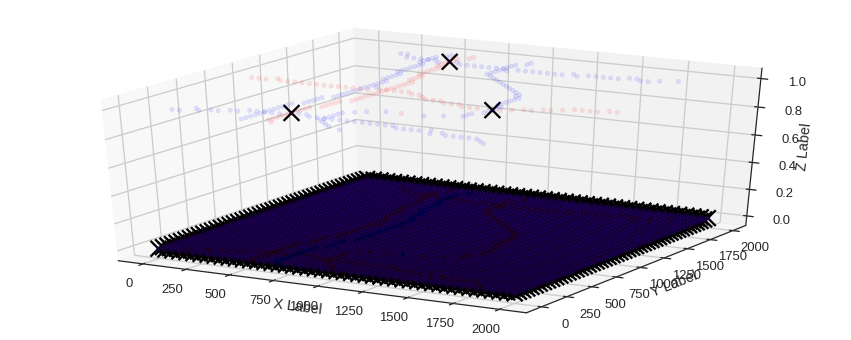

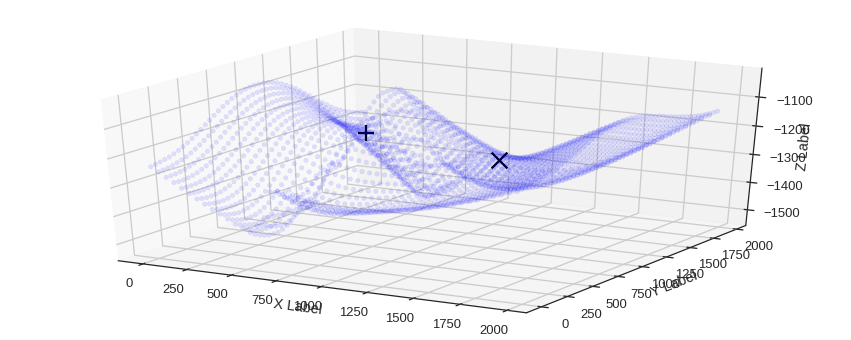

SPILL POINT: [ 1428.57141113   775.51019287 -1205.09272854]
Leak Point: [  612.24487305   938.7755127  -1187.53193138]
Fault leak point above spill point.
...but fault sealing. Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 20
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 33152000.0 m³


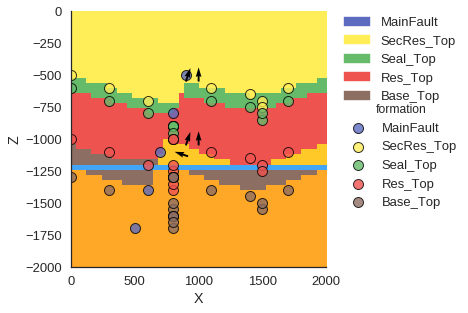

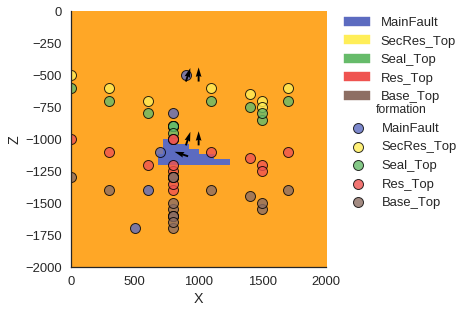

In [17]:
# MODLE FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top):
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    print('Z-Variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'] = new_z_secres_top
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'] = new_z_seal_top
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'] = new_z_res_top
    interp_data.geo_data_res.interfaces['Z'][interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'] = new_z_base_top
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled X-position 1600, we simply calculated 2000-400 rescaled (see fw_x_cond)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    rescale_f = interp_data.rescaling_factor
    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
    points_fw = points_fw[y_mid]   
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    rescale_f = interp_data.rescaling_factor
    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
    points_fw = points_fw[y_mid]   
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    rescale_f = interp_data.rescaling_factor
    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
    points_fw = points_fw[y_mid]   
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data=interp_unc, fault_sealing=fault_sealing):
    lith_sol, fault_sol = gp.compute_model(interp_data)
    lith_block = lith_sol[0,0]
    fault_block = fault_sol[0,0]  
    res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                          interp_data = interp_data, potential_lith=lith_sol[0,1], 
        potential_fault=fault_sol[0,1], n_formation = interp_data.get_formation_number()['Res_Top'])
    max_vol, lith_sol[0,0], bottom, trap = max_trap_vol(interp_data, lith_block, fault_block, res_top_surf, fault_sealing)
    print("Maximum reservoir volume: %s m³" % max_vol)
    #gp.plot_section(geo_data, lith_sol[0,0], 5, plot_data =1)
    gp.plot_section(geo_data, lith_sol[0,0], 25, plot_data =1)
    #gp.plot_section(geo_data, lith_sol[0,0], 45, plot_data =1)
    gp.plot_section(geo_data, trap, 25, plot_data =1)
    return lith_sol, fault_sol, max_vol

In [18]:
iterations = 10

In [ ]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, fault_sealing, structural_model, res_th, seal_th, sec_res_th])

Z-Variations top to bottom: -3.02193109906 -36.704179085 8.38411637277 -55.8025064722


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Serie

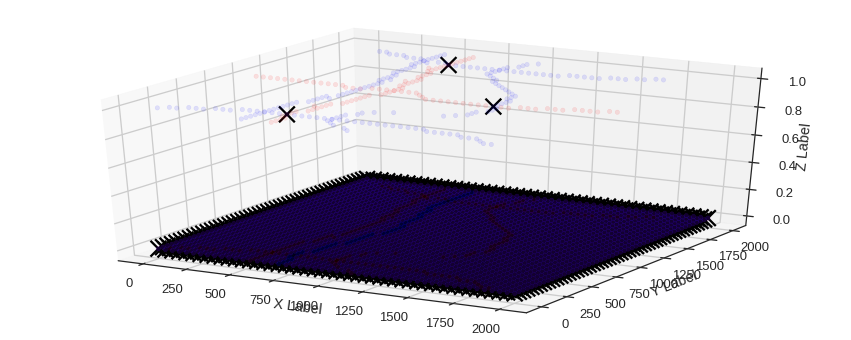

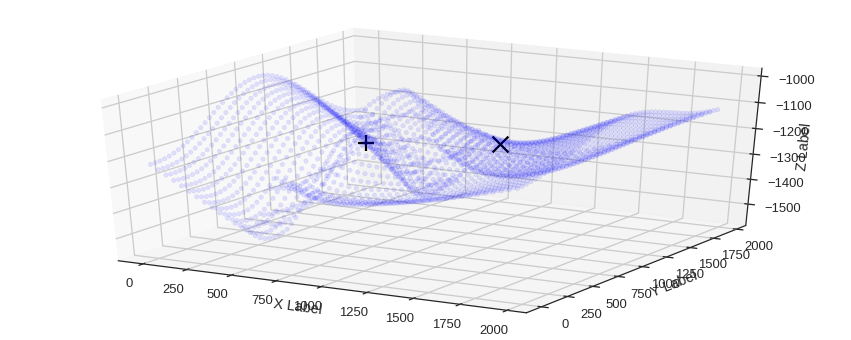

SPILL POINT: [ 1387.75512695   857.1428833  -1150.38188192]
Leak Point: [  612.24487305   938.7755127  -1213.97293343]
Spill point defines trap.
Fault is sealing. Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 20
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 14528000.0 m³
 [-------          20%                  ] 2 of 10 complete in 13.4 secZ-Variations top to bottom: 7.19771795431 -33.7988911663 -52.1045496949 -34.4103779401


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0724387917586684e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


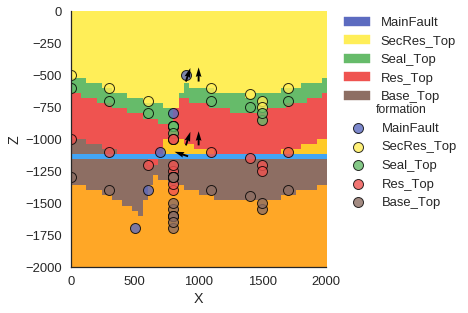

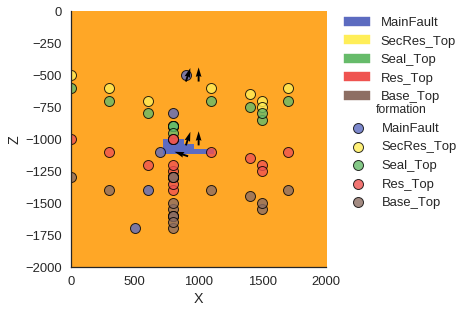

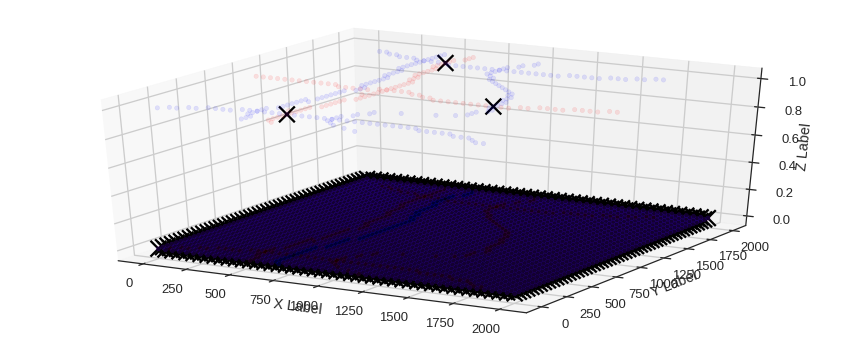

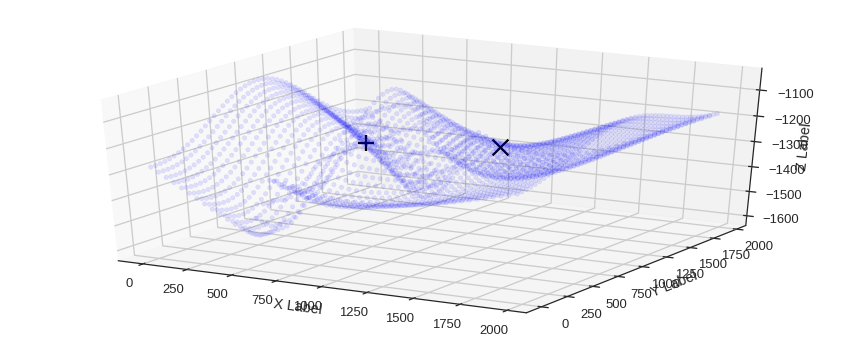

SPILL POINT: [ 1387.75512695   857.1428833  -1209.15109854]
Leak Point: [  612.24487305   938.7755127  -1265.56509209]
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 20
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 23616000.0 m³
 [-----------      30%                  ] 3 of 10 complete in 27.4 secZ-Variations top to bottom: 4.33183945247 -6.17836558041 23.1365817015 56.4912053956


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.5230649167151675e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


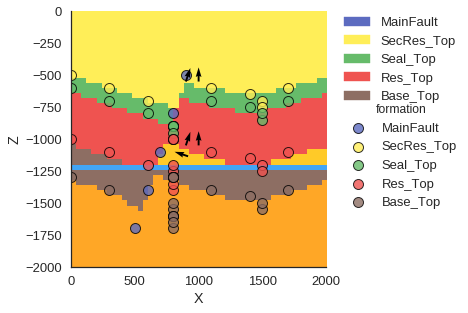

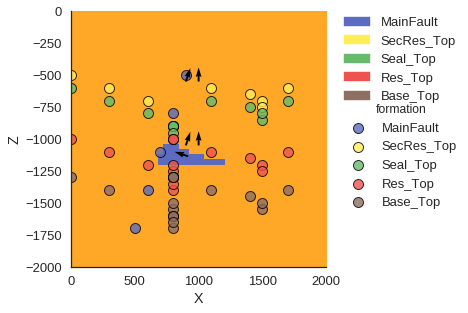

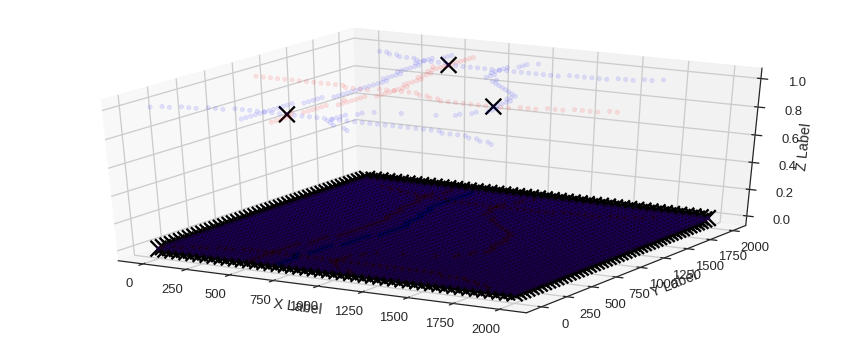

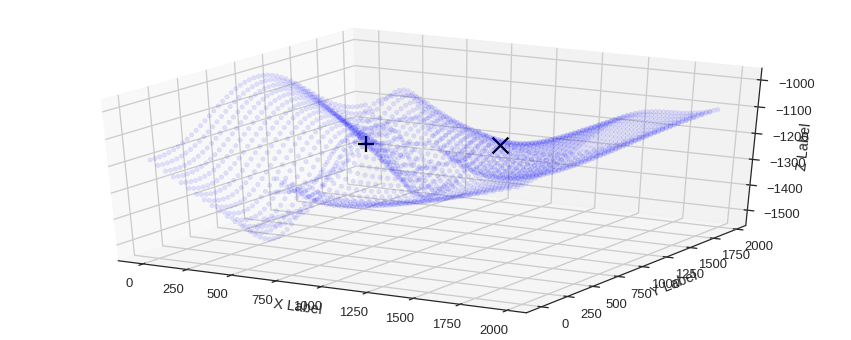

SPILL POINT: [ 1387.75512695   857.1428833  -1136.05237006]
Leak Point: [  612.24487305   938.7755127  -1201.36361594]
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 20
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 18624000.0 m³
 [---------------  40%                  ] 4 of 10 complete in 40.9 secZ-Variations top to bottom: -5.02639684253 -3.65168395431 16.2261244749 50.9375280179


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.8979443017208553e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


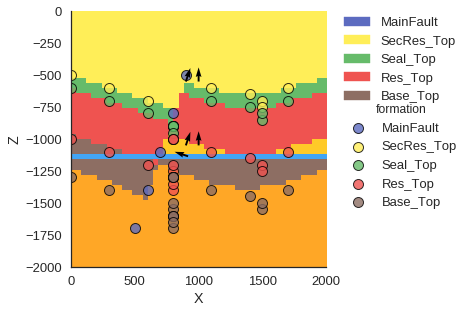

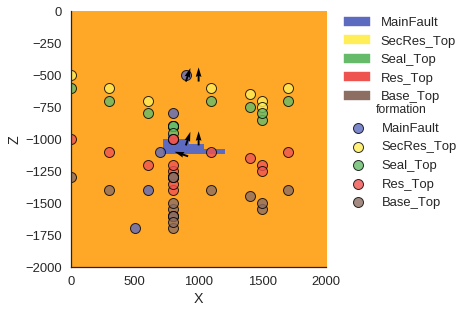

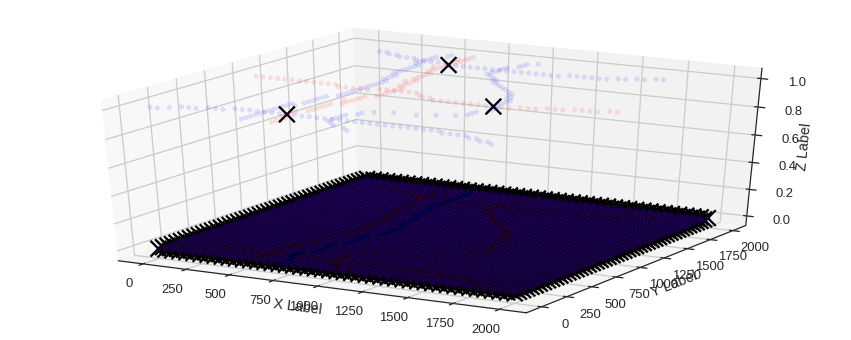

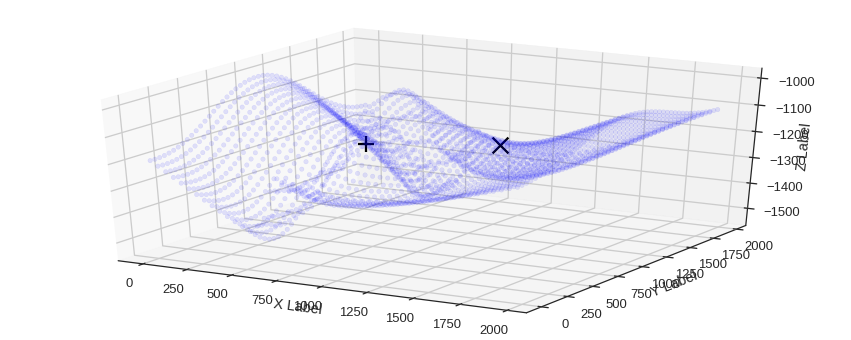

SPILL POINT: [ 1387.75512695   857.1428833  -1142.92159508]
Leak Point: [  612.24487305   938.7755127  -1208.89237241]
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 20
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 16320000.0 m³
 [-----------------50%                  ] 5 of 10 complete in 54.3 secZ-Variations top to bottom: 14.2327556545 8.78268009024 -3.62864618437 61.3070340656


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.6842294012507928e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


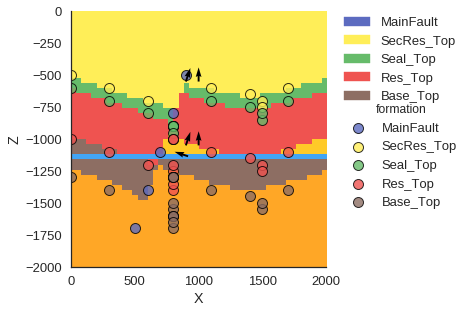

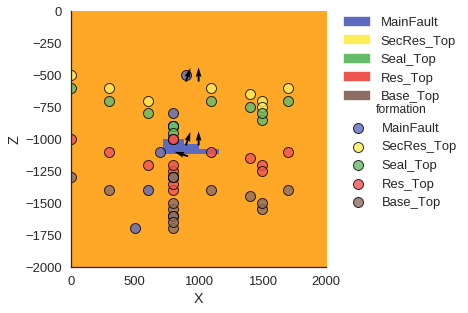

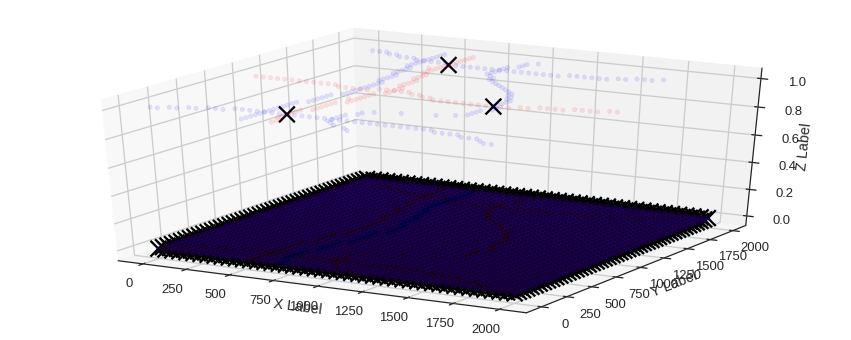

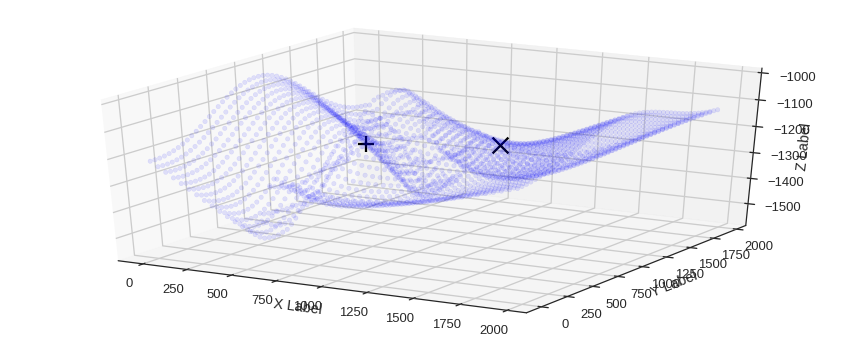

SPILL POINT: [ 1387.75512695   857.1428833  -1162.50656221]
Leak Point: [  612.24487305   938.7755127  -1228.59285463]
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 20
Checking Section: 17
TRAP FOUND, section: 17
Maximum reservoir volume: 11584000.0 m³
 [-----------------60%--                ] 6 of 10 complete in 68.3 secZ-Variations top to bottom: -3.26510004778 1.31900107755 -7.49531788949 -20.9200924344


In [ ]:
M = pymc.MCMC(model)
M.sample(iter=iterations)

In [445]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

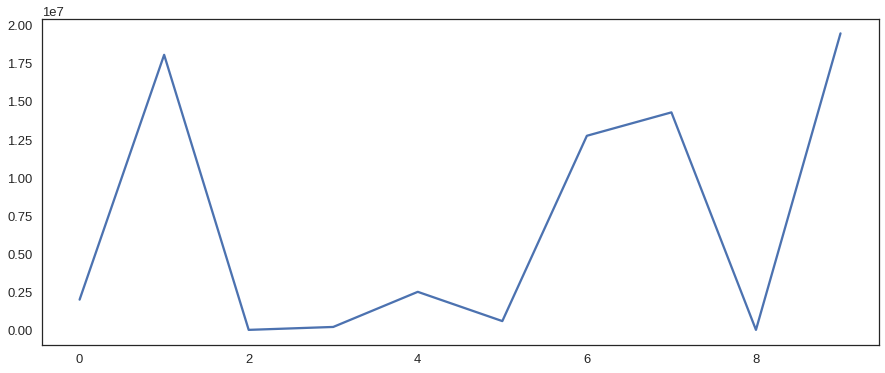

In [446]:
max_volume_trace = structural_model_trace[:,2]
plt.plot(max_volume_trace)

ZeroDivisionError: integer division or modulo by zero

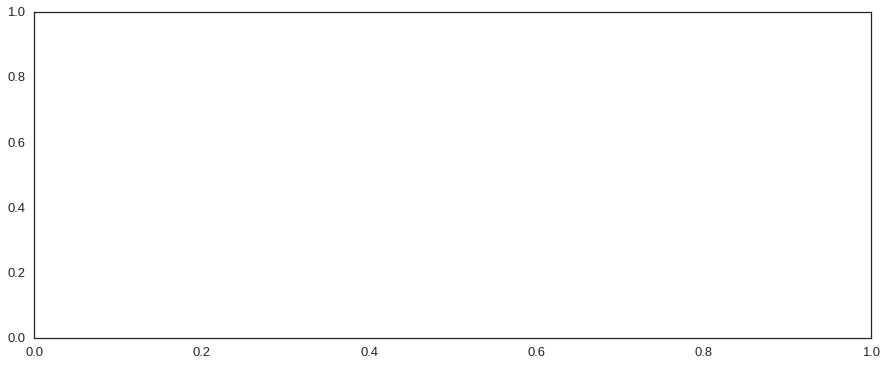

In [447]:
plt.plot(fw_res_th_trace)
plt.plot(fw_seal_th_trace)
plt.plot(fw_sec_res_th_trace)

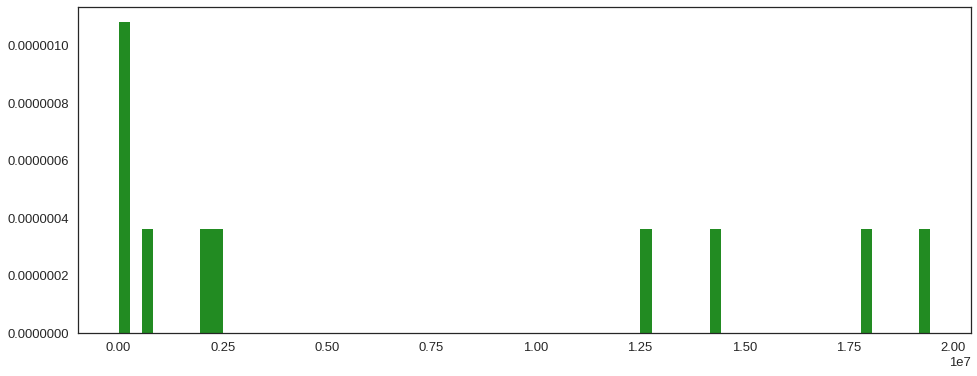

In [448]:
figsize(16, 6)

#_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")
volumes = max_volume_trace
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "forestgreen")
#_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [44]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s
    
#def volume_lossR(estimate_s, true_s, risk_s):
#        loss_s = np.zeros_like(true_s)
#        underest = (estimate_s < true_s) 
#        underest_bad = (estimate_s <= 0) & (true_s > 0)
#        overest = (estimate_s > true_s) 
#        overest_bad = (estimate_s > 0) & (true_s <= 0)
#        loss_s[underest] = (true_s[underest] - estimate_s)
#        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
#        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
#        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
#        return loss_s

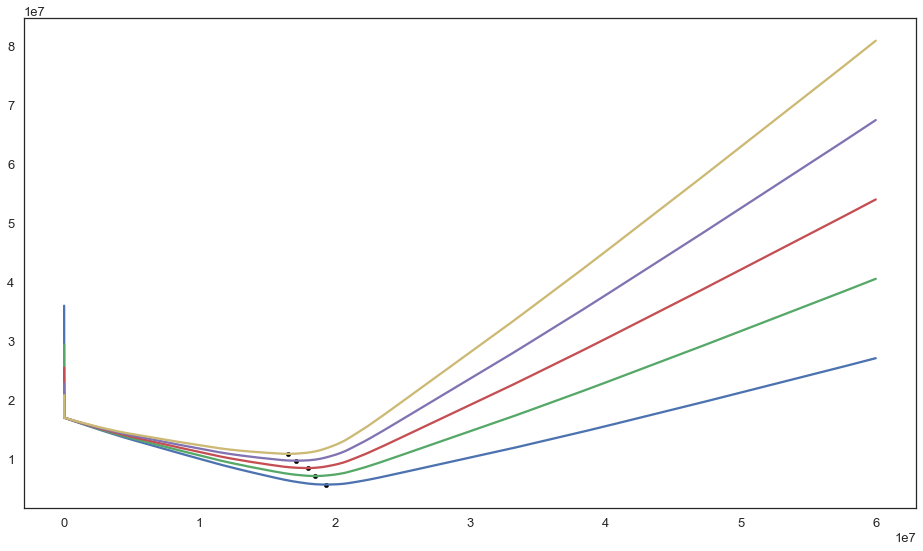

In [45]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


In [534]:
# ADDING THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 10
std2 = 20
std3 = 50

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 400., 1./np.square(std2))

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 120., 1./np.square(std1))

Z-Variations top to bottom: -32.1186581584 -10.0512387546 -0.079112507637 14.7345492212
Z-Variations top to bottom: -16.1131417183 -10.0512387546 -0.0340639651887 14.7345492212
Z-Variations top to bottom: -16.1131417183 -10.0512387546 -0.0340639651887 2.28878044073
Z-Variations top to bottom: -16.1131417183 6.73883614958 -0.0340639651887 2.28878044073


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Boolean Serie

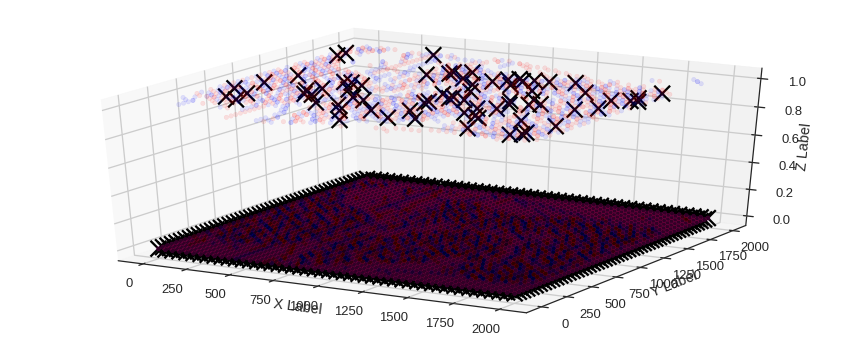

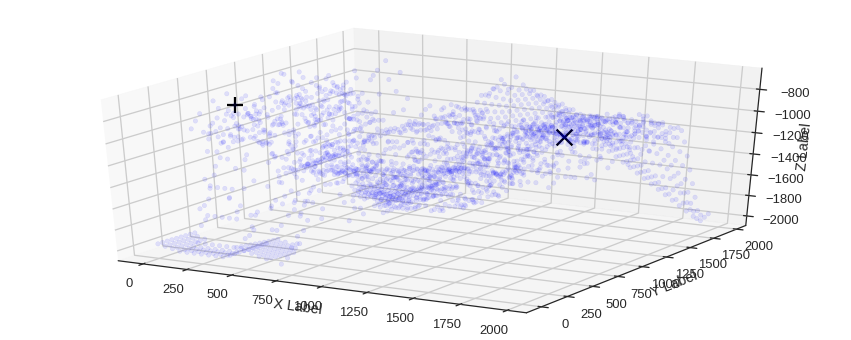

SPILL POINT: [ 1877.55102539   571.42858887  -793.17891348]
Leak Point: [  40.81632614  693.87756348 -877.1164571 ]
Spill point defines trap.
Fault is pathway. Down to spill.


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


Checking Section: 167
TRAP FOUND, section: 167
Checking Section: 210
Maximum reservoir volume: 2240000.0 m³
 [-------          20%                  ] 2 of 10 complete in 14.3 secZ-Variations top to bottom: -7.46412436853 6.73883614958 -0.0340639651887 2.28878044073
Z-Variations top to bottom: -7.46412436853 6.73883614958 -0.014931290841 2.28878044073
Z-Variations top to bottom: -7.46412436853 6.73883614958 -0.014931290841 18.1260116929
Z-Variations top to bottom: -7.46412436853 5.828666834 -0.014931290841 18.1260116929


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.7924767493091593e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


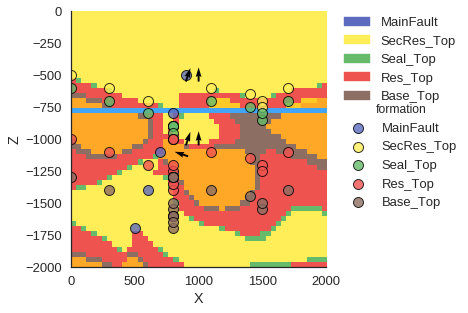

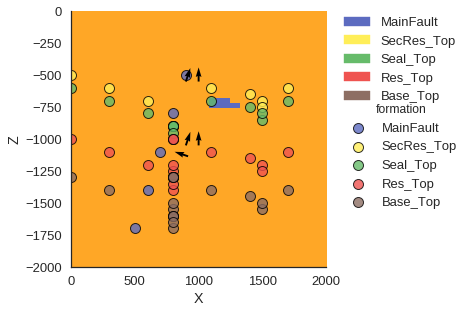

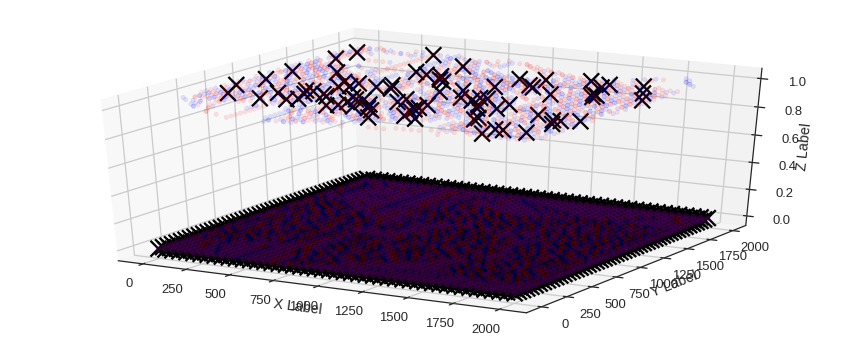

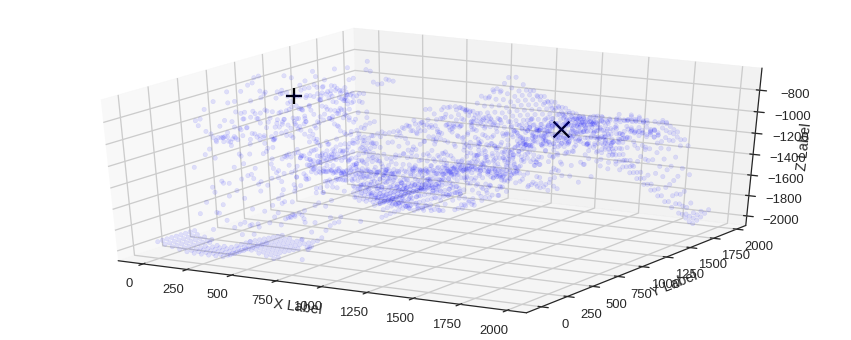

SPILL POINT: [ 1795.91833496   693.87756348  -766.81893627]
Leak Point: [   40.81632614  1224.48974609  -944.7688156 ]
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 43
TRAP FOUND, section: 43
Checking Section: 46
Checking Section: 42
TRAP FOUND, section: 42
Checking Section: 12
Maximum reservoir volume: 2240000.0 m³
 [-----------      30%                  ] 3 of 10 complete in 28.3 secZ-Variations top to bottom: -1.11795377144 5.828666834 -0.014931290841 18.1260116929
Z-Variations top to bottom: -1.11795377144 5.828666834 0.0360410559709 18.1260116929
Z-Variations top to bottom: -1.11795377144 5.828666834 0.0360410559709 9.08087287547
Z-Variations top to bottom: -1.11795377144 0.948141764198 0.0360410559709 9.08087287547


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.064944131825342e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


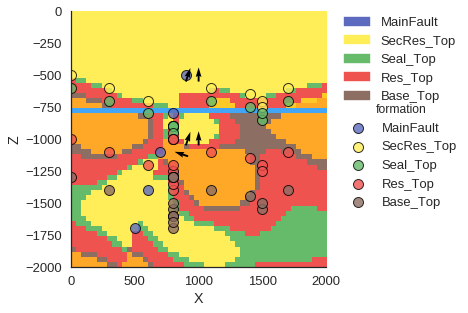

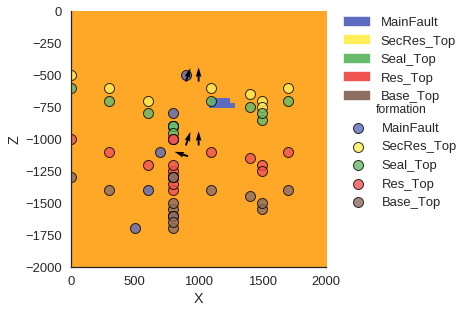

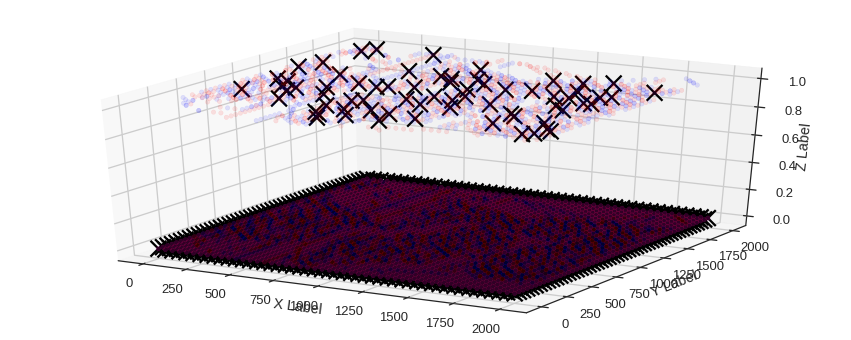

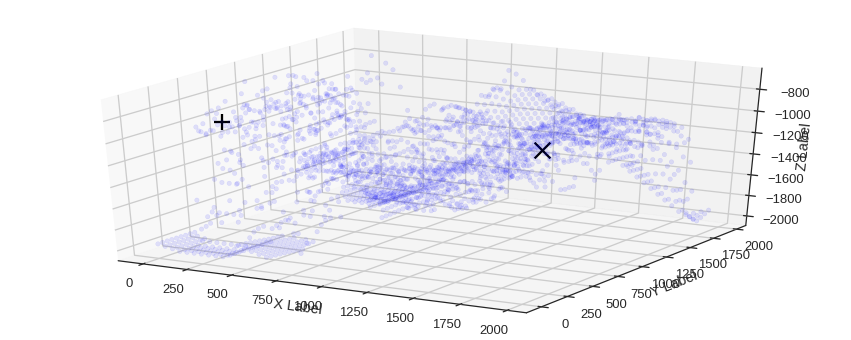

SPILL POINT: [ 1877.55102539   367.34692383  -843.23186025]
Leak Point: [ 122.44898224  448.97958374 -941.8888795 ]
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 38
Checking Section: 42
No trap found! =(
Maximum reservoir volume: 0.0 m³
 [---------------  40%                  ] 4 of 10 complete in 42.0 secZ-Variations top to bottom: 2.76396131042 0.948141764198 0.0360410559709 9.08087287547
Z-Variations top to bottom: 2.76396131042 0.948141764198 -0.0226001053029 9.08087287547
Z-Variations top to bottom: 2.76396131042 0.948141764198 -0.0226001053029 21.9929754424
Z-Variations top to bottom: 2.76396131042 -5.40641865679 -0.0226001053029 21.9929754424


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0688635740385699e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


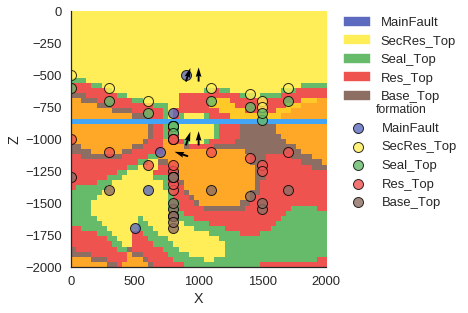

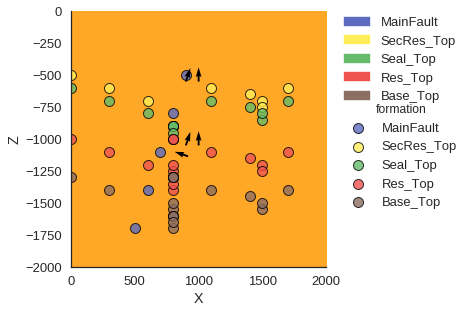

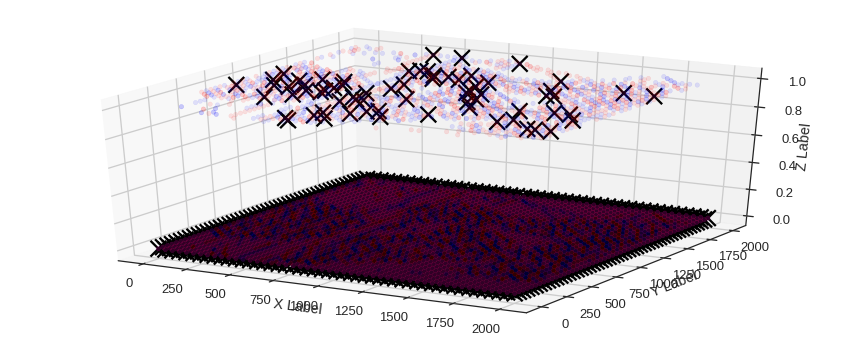

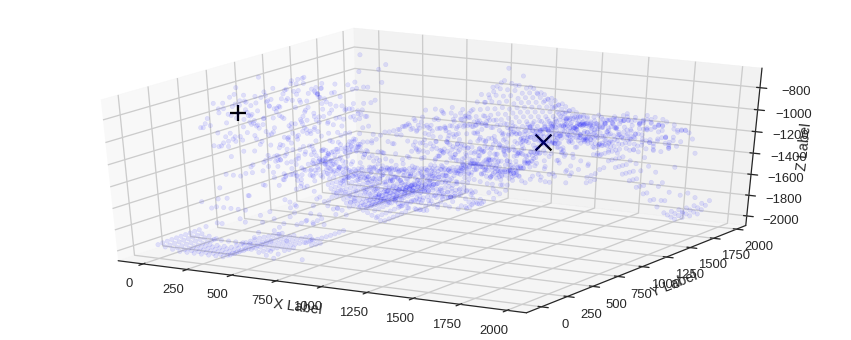

SPILL POINT: [ 1836.73474121   448.97958374  -816.61028459]
Leak Point: [  81.63265228  653.06121826 -947.28121848]
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 43
Checking Section: 46
TRAP FOUND, section: 46
Checking Section: 39
TRAP FOUND, section: 39
Checking Section: 36
Checking Section: 41
TRAP FOUND, section: 41
Maximum reservoir volume: 3776000.0 m³
 [-----------------50%                  ] 5 of 10 complete in 56.7 secZ-Variations top to bottom: 15.1452451644 -5.40641865679 -0.0226001053029 21.9929754424
Z-Variations top to bottom: 15.1452451644 -5.40641865679 -0.0810943772154 21.9929754424
Z-Variations top to bottom: 15.1452451644 -5.40641865679 -0.0810943772154 -2.90136010638
Z-Variations top to bottom: 15.1452451644 -9.26089148012 -0.0810943772154 -2.90136010638


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.7004187908307173e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


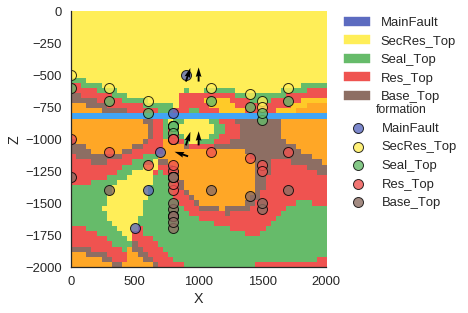

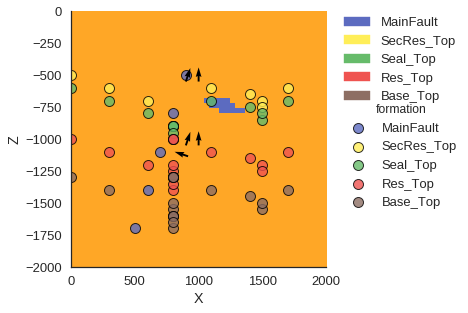

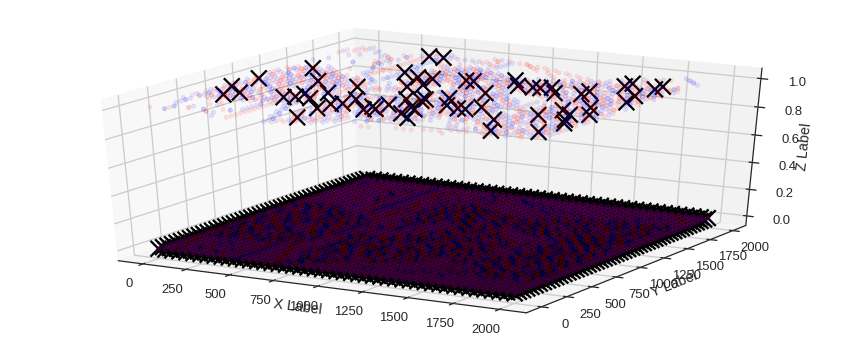

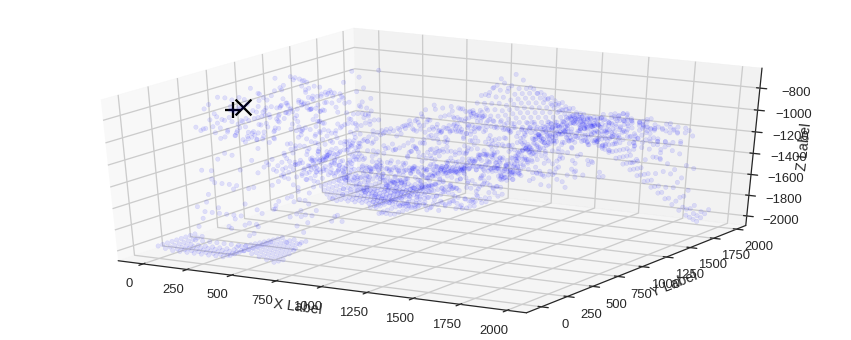

SPILL POINT: [ 163.26530457  571.42858887 -847.96476675]
Leak Point: [  81.63265228  612.24487305 -903.12304361]
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 35
Checking Section: 39
Checking Section: 38
TRAP FOUND, section: 38
Maximum reservoir volume: 64000.0 m³
 [-----------------60%--                ] 6 of 10 complete in 70.4 secZ-Variations top to bottom: 30.293782219 -9.26089148012 -0.0810943772154 -2.90136010638
Z-Variations top to bottom: 15.1452451644 -9.26089148012 -0.142725035549 -2.90136010638
Z-Variations top to bottom: 15.1452451644 -9.26089148012 -0.142725035549 -4.05177269181
Z-Variations top to bottom: 15.1452451644 -21.7374645945 -0.142725035549 -4.05177269181


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.5203967385367676e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


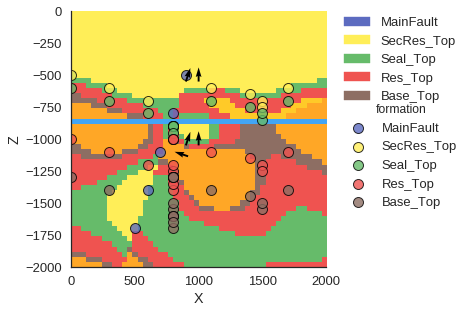

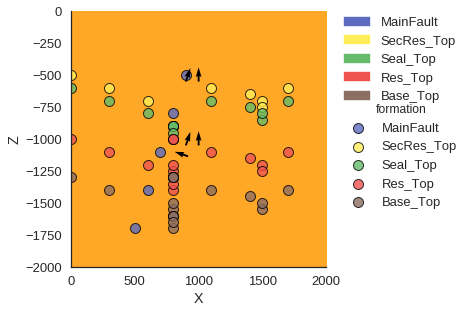

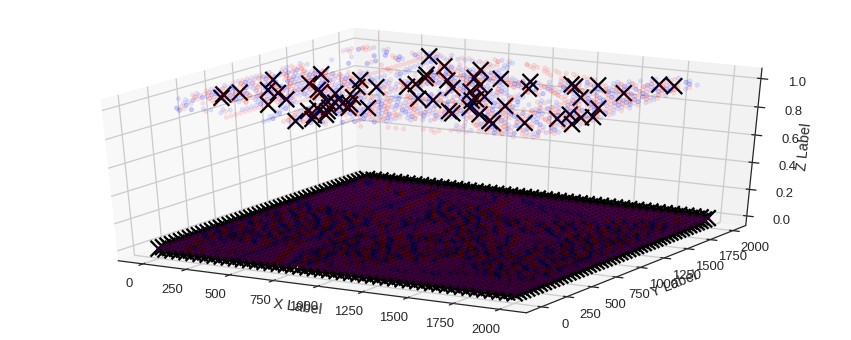

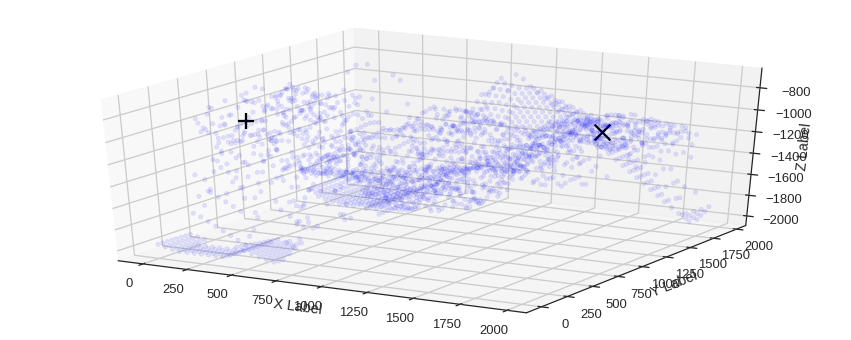

SPILL POINT: [ 1918.36730957   857.1428833   -844.04478907]
Leak Point: [ 204.08163452  530.61224365 -953.70805391]
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 39
TRAP FOUND, section: 39
Checking Section: 41
Checking Section: 40
TRAP FOUND, section: 40
Checking Section: 16
TRAP FOUND, section: 16
Checking Section: 35
Checking Section: 17
TRAP FOUND, section: 17
Checking Section: 38
TRAP FOUND, section: 38
Maximum reservoir volume: 6528000.0 m³
 [-----------------70%------            ] 7 of 10 complete in 88.5 secZ-Variations top to bottom: 12.6721767277 -21.7374645945 -0.142725035549 -4.05177269181
Z-Variations top to bottom: 12.6721767277 -21.7374645945 -0.266141068741 -4.05177269181
Z-Variations top to bottom: 12.6721767277 -21.7374645945 -0.266141068741 -15.7671654229
Z-Variations top to bottom: 12.6721767277 -25.3631647578 -0.266141068741 -15.7671654229


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.708104557939798e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


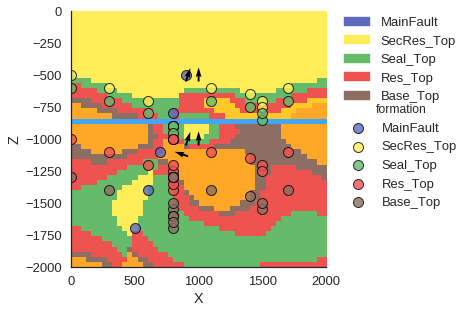

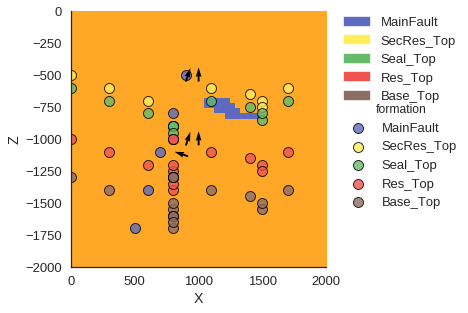

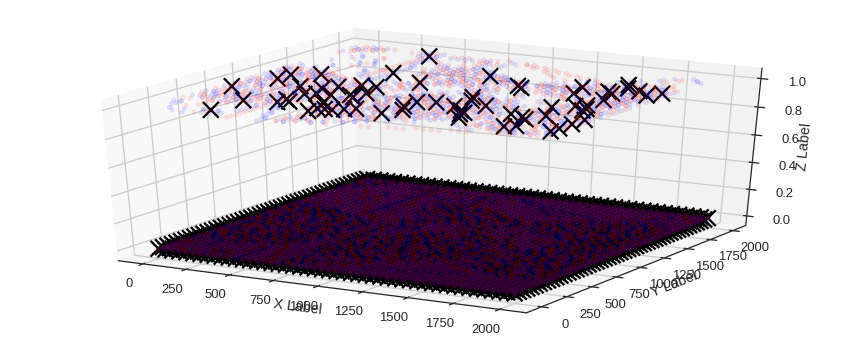

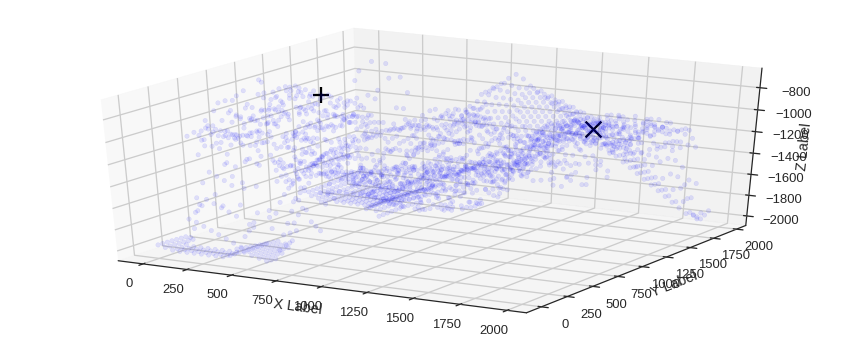

SPILL POINT: [ 1918.36730957   775.51019287  -791.11426744]
Leak Point: [  244.89796448  1142.85717773  -896.45717117]
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 37
TRAP FOUND, section: 37
Checking Section: 39
Checking Section: 16
TRAP FOUND, section: 16
Maximum reservoir volume: 2560000.0 m³
 [-----------------80%----------        ] 8 of 10 complete in 102.2 secZ-Variations top to bottom: 26.3523549431 -25.3631647578 -0.266141068741 -15.7671654229
Z-Variations top to bottom: 12.6721767277 -25.3631647578 -0.279271804772 -15.7671654229
Z-Variations top to bottom: 12.6721767277 -25.3631647578 -0.279271804772 -28.0922426287
Z-Variations top to bottom: 12.6721767277 -31.2237674001 -0.279271804772 -28.0922426287


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.090502676162844e-12
  ' condition number: {}'.format(rcond), RuntimeWarning)


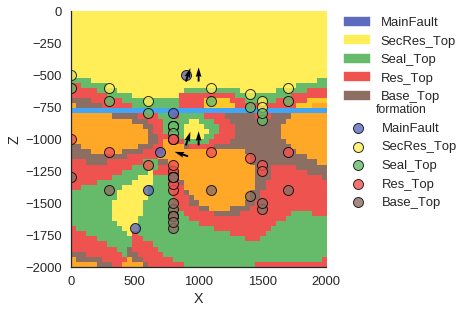

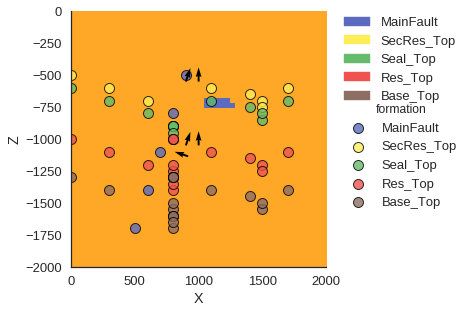

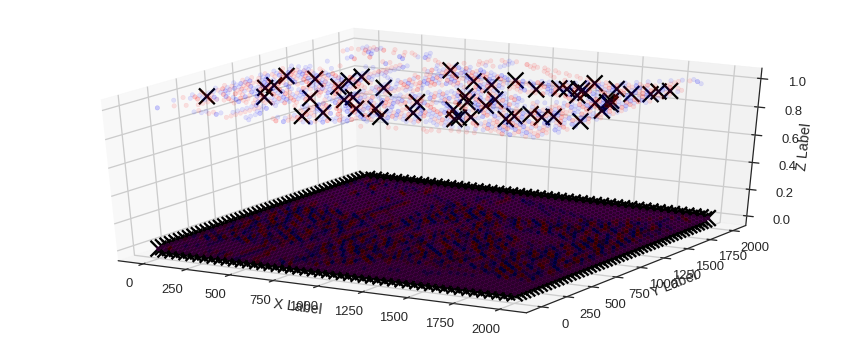

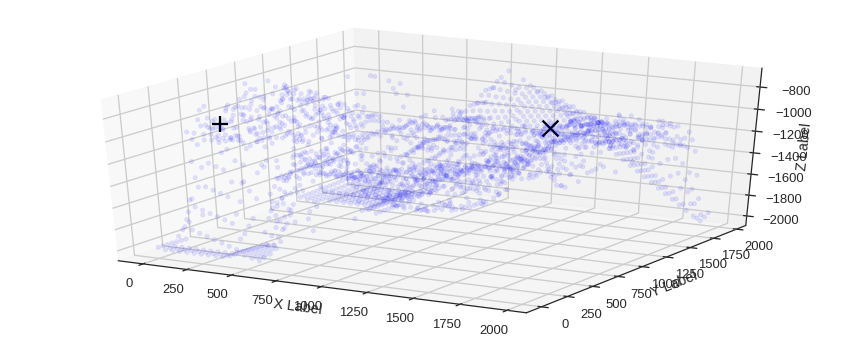

SPILL POINT: [ 1714.2857666    734.69384766  -817.66190618]
Leak Point: [ 163.26530457  367.34692383 -945.97159961]
Spill point defines trap.
Fault is sealing. Down to spill.
Checking Section: 37
Checking Section: 42
TRAP FOUND, section: 42
Checking Section: 40
TRAP FOUND, section: 40
Checking Section: 41
Checking Section: 19
TRAP FOUND, section: 19
Maximum reservoir volume: 4352000.0 m³
 [-----------------90%--------------    ] 9 of 10 complete in 116.4 secZ-Variations top to bottom: 20.6643425468 -31.2237674001 -0.279271804772 -28.0922426287
Z-Variations top to bottom: 12.6721767277 -31.2237674001 -0.280570314676 -28.0922426287
Z-Variations top to bottom: 12.6721767277 -31.2237674001 -0.280570314676 -11.1390506439
Z-Variations top to bottom: 12.6721767277 -41.2434611034 -0.280570314676 -11.1390506439


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.117044982183572e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


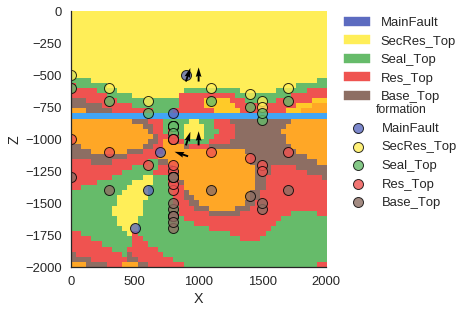

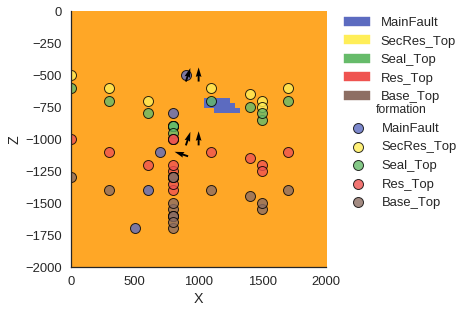

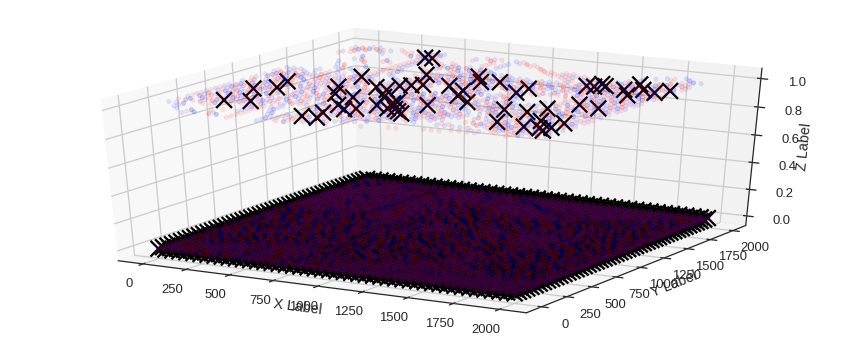

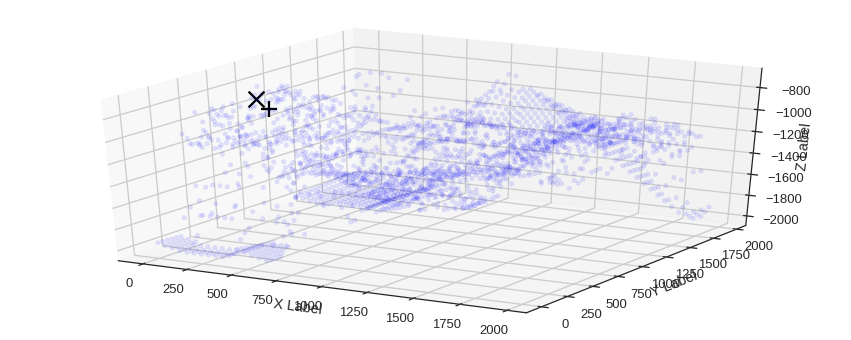

SPILL POINT: [ 163.26530457  693.87756348 -820.80505889]
Leak Point: [ 204.08163452  734.69384766 -913.27985337]
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 37
TRAP FOUND, section: 37
Checking Section: 34
Checking Section: 36
TRAP FOUND, section: 36
Checking Section: 40
Maximum reservoir volume: 3968000.0 m³
 [-----------------100%-----------------] 10 of 10 complete in 130.2 secZ-Variations top to bottom: 15.9199538953 -41.2434611034 -0.280570314676 -11.1390506439
Z-Variations top to bottom: 15.9199538953 -41.2434611034 -0.255845950362 -11.1390506439
Z-Variations top to bottom: 15.9199538953 -41.2434611034 -0.255845950362 -20.1761372962
Z-Variations top to bottom: 15.9199538953 -51.3292078352 -0.255845950362 -20.1761372962


/home/bl9/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.0747331764002794e-11
  ' condition number: {}'.format(rcond), RuntimeWarning)


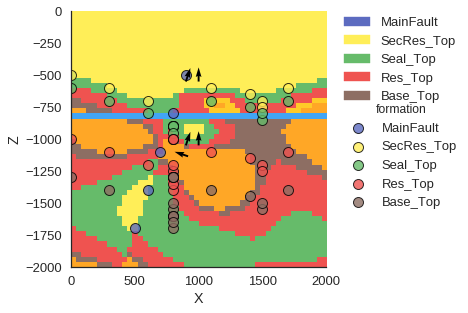

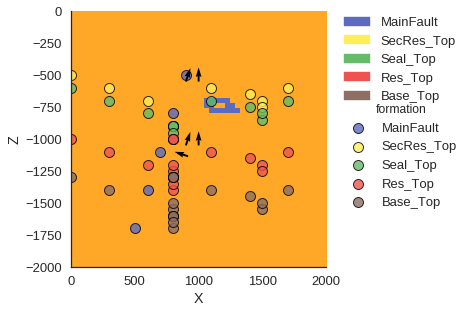

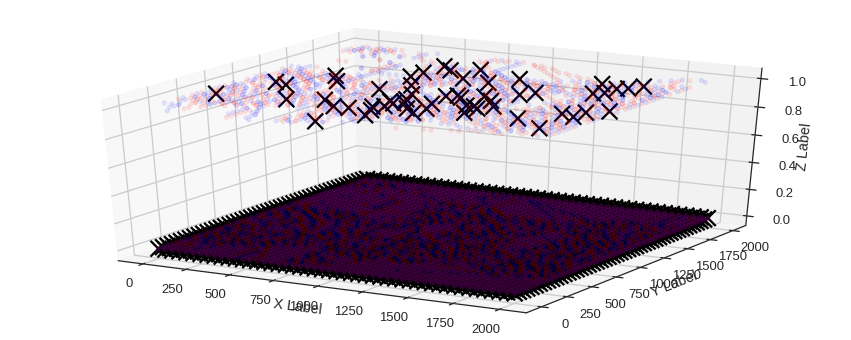

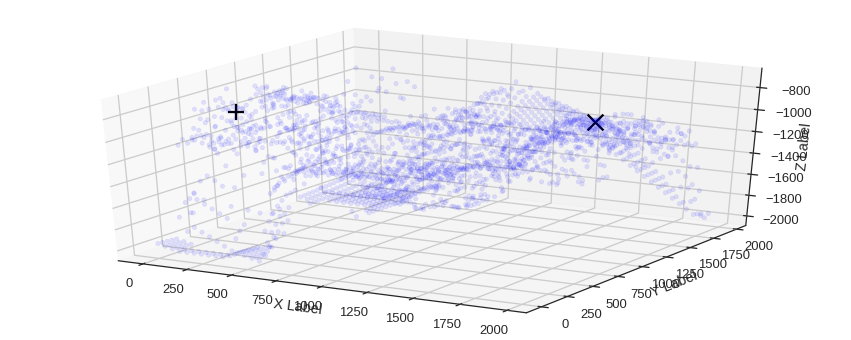

SPILL POINT: [ 1836.73474121   938.7755127   -798.92203612]
Leak Point: [ 122.44898224  571.42858887 -905.85443758]
Spill point defines trap.
Fault is pathway. Down to spill.
Checking Section: 11
Checking Section: 38
TRAP FOUND, section: 38
Checking Section: 45
Maximum reservoir volume: 1600000.0 m³
 [------------------110%-------------------] 11 of 10 complete in 144.2 sec

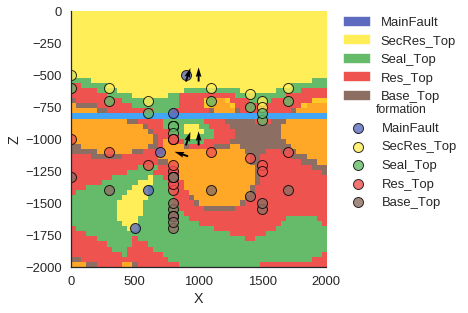

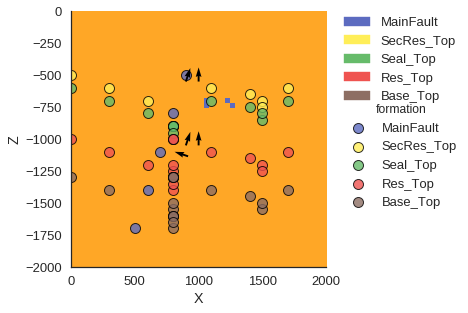

In [535]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, 
                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])


M = pymc.MCMC(model)
M.sample(iter=iterations)

In [459]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

interp_trace = M.trace('interp_unc')[:]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

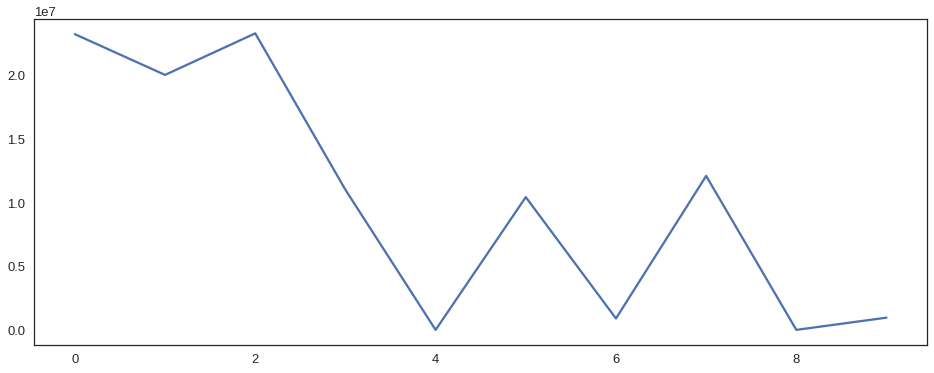

In [460]:
max_volume_trace = structural_model_trace[:,2]
plt.plot(max_volume_trace)

ZeroDivisionError: integer division or modulo by zero

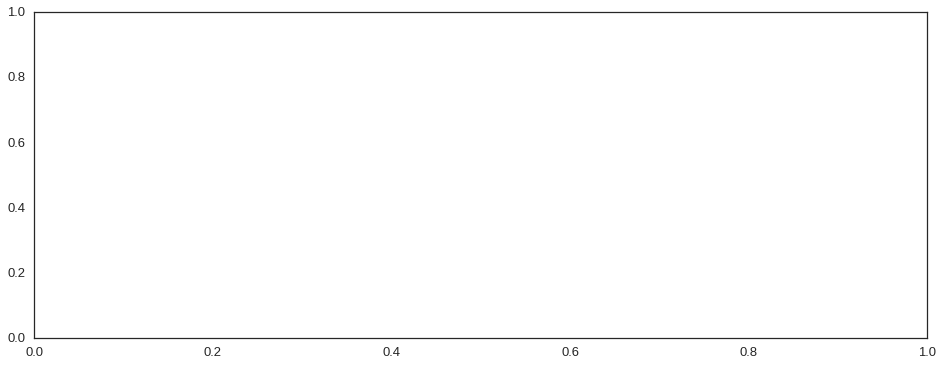

In [462]:
plt.plot(fw_res_th_trace)
plt.plot(fw_seal_th_trace)
plt.plot(fw_sec_res_th_trace)

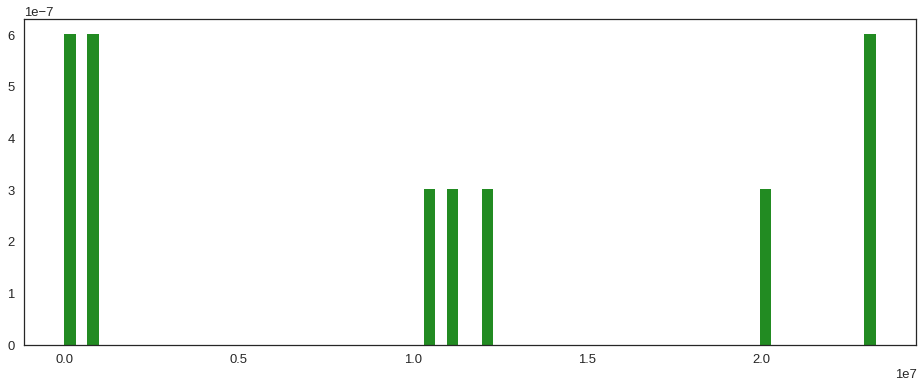

In [461]:
figsize(16, 6)

#_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")
volumes = max_volume_trace
mask = volumes == 0
masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "forestgreen")
#_hist1 = plt.hist(masked_trace, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

In [464]:
figsize(16, 9)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss(_min_score,r)
    counter += 1


NameError: name 'risks_s' is not defined

In [12]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL BASED ON VOXEL-COUNTING
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
#def fw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    
#    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#
## Hanging wall at X = 600 and Y = 1000
#def hw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
#    return hw_res_th, hw_seal_th, hw_sec_res_th

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS USING GEO_DATA
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [206]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)

In [248]:
#a,b = np.gradient(grid_z0, 40.81632614)
#a = np.rot90(a,-1)
#
#asign = np.sign(a)
#asignchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
#
##print(asignchange)
#asignchange2 = ((np.roll(asign, -1) - asign) != 0).astype(int)
#
#
#asc3 = np.logical_or(asignchange, asignchange2)
#
#asc3[:,0]= 0
#asc3[:,1]= 0
#asc3[:,-1] = 0
#asc3[-1,:] = 0
#print(asc3)
#
#bsign = np.sign(b)
#bsignchange = ((np.roll(bsign, 1) - bsign) != 0).astype(int)
#bsignchange2 = ((np.roll(bsign, -1) - bsign) != 0).astype(int)
#
#bsc3 = np.logical_or(bsignchange, bsignchange2)
#
#bsc3[:,0]= 0
#bsc3[:,-1] = 0
#bsc3[:,-2] = 0
#bsc3[:,-3] = 0
#bsc3[-1,:] = 0
##print(bsignchange)
#
#
#asignchange = np.rot90(asignchange,1)
#asc3 = np.rot90(asc3,1)
#
#c = np.logical_and(asc3,bsc3)

[[False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False False  True
   True False]
 [False False  True False False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False  True  True
  False False]
 [False False  True  True False False False False False False False False
  False False False False False False False False False False False False
  False  True  True False False False False False False False False False
  False False False False False False False False False False  True  True
  False False]
 [False False  True  True False False False False False False False

In [333]:
#grad_zero = saddle_p_all == 1
#grid_z0[~grad_zero]= np.nan
#grid_z0

array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,

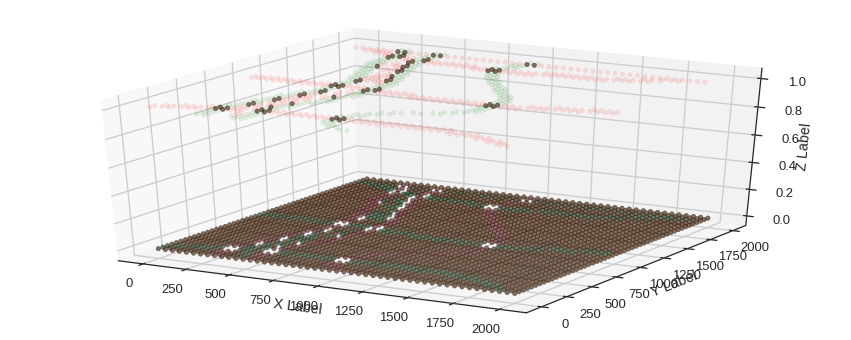

In [249]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, asc3, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, bsc3, c="g", alpha = 0.1)
#ax.scatter(grid_x, grid_y, c, c="black", alpha = 0.5)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

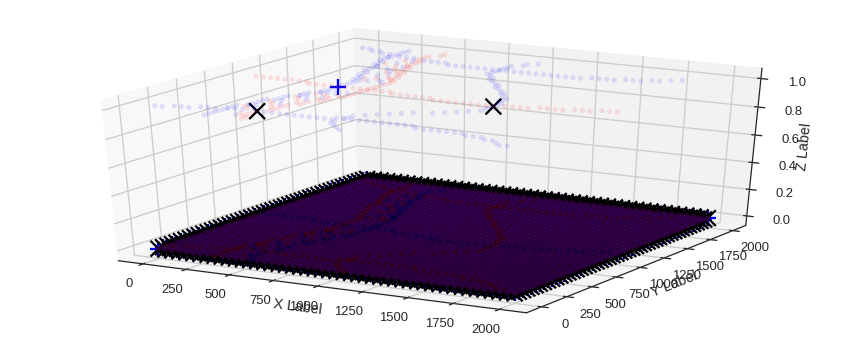

In [372]:
#fault_line = grid_minX[grid_maxX]
#figsize(15,6)
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
#ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
#ax.scatter(grid_x, grid_y, spill_points, c="black", alpha = 1, marker='x', s = 250)
#ax.scatter(grid_x, grid_y, leak_point, c="b", alpha = 1, marker='+', s= 250)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

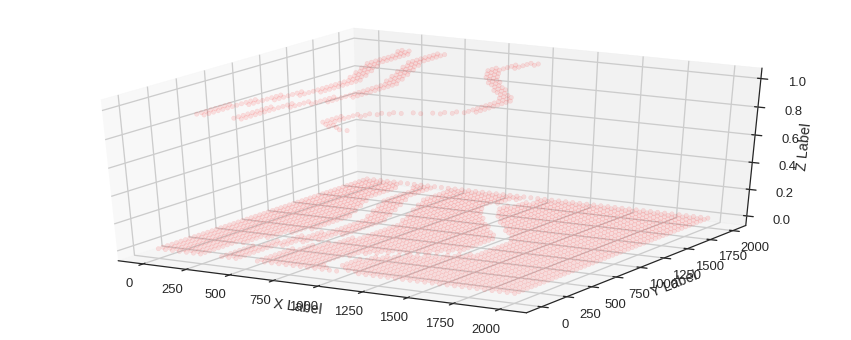

In [245]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
##ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
##ax.scatter(grid_x, grid_y, -a, c="r", alpha = 0.1)
##ax.scatter(grid_x, grid_y, -asignchange, c="g", alpha = 0.1)
#ax.scatter(grid_x, grid_y, bsc3, c="r", alpha = 0.1)
#
#ax.set_xlabel('X Label')
#ax.set_ylabel('Y Label')
#ax.set_zlabel('Z Label')
#
#plt.show()

In [403]:
# SPILL AND LEAK POINT FUNCTIONS

# Finding the spill point
#def spill_point(res_surface):
#    mini = argrelextrema(res_surface[:,2], np.less, order=10)
#    minima = np.array(list(zip(np.take(res_surface[:,1], mini[0]), np.take(res_surface[:,0], mini[0]), np.take(res_surface[:,2], mini[0]))))
#    fault_thresh = minima[:,1] > 700 #taking only relevant side by setting a threshold visually estimated, best: 20
#    spill_min_line = minima[fault_thresh]
#    spill_pos = np.array(np.argmax(spill_min_line[:,2]))
#    spill_z = np.take(spill_min_line[:,2], spill_pos)
#    spill_p = np.array([np.take(spill_min_line[:,1], spill_pos), np.take(spill_min_line[:,0],
#                                spill_pos), np.take(spill_min_line[:,2], spill_pos)])
#    
#    # Horizontal plane defined by z-pos of spill
#    if True:
#        spill_bottom = np.ones_like(res_surface)
#        spill_bottom[:,0] = res_surface[:,0]
#        spill_bottom[:,1] = res_surface[:,1]
#        spill_bottom[:,2] = spill_z    
#    
#    return spill_z, spill_p, spill_min_line, spill_bottom
#
## Finding the leak point ( critically inefficient method! takes 10s!)
#def leak_point(res_surface):
#    counter = 0
#    # Creating empty lists and arrays to save values
#    xvals = []
#    yvals = []
#    zvals = []
#    leak_min = np.empty((0,3), dtype=int)
#    #leak_min = np.empty([3,], dtype=int)
#    
#    for i in np.unique(res_surface[:,1]):
#        
#    #while counter < model_size:
#        #print(counter)
#        for e in res_surface:
#            # Looking at a slice along y-axis for y = e[1] = counter, 
#            # and appending x,y,z-values into lists
#            # This is a way of RESORTING the array as needed
#            #if int(e[1]) == counter:
#            if e[1] == i:
#                xvals.append(e[0])
#                yvals.append(e[1])
#                zvals.append(e[2])
#            
#        # Saving x,y,z-values as lists/arrays      
#        zvals = np.array(zvals)
#        yvals = np.array(yvals)
#        xvals = np.array(xvals)
#
#        # Looking fore minima positions in z-array
#        min_pos = argrelextrema(zvals, np.less, order=10)
#        
#        # Saving x,y,z-positions of minima
#        ypos = yvals[min_pos]
#        xpos = xvals[min_pos]
#        mins = zvals[min_pos]
#        
#        # Condition: Check if any minimum was found and if any data is given at y = counter
#        # If no minimum found, restart loop at next iteration
#        # This way, we can work with the data that coesn't cover every 1 step along the model
#        # (such as the surface vertices)
#        if len(mins) == 0:
#            counter += 1
#            #lists have to be emptied again
#            xvals = []
#            yvals = []
#            zvals = []
#            continue
#        
#        #np.append(leak_min, mins) -----> what did I use this for?
#        
#        # Create and array element to save coordinates of minima
#        mins_pos = np.array(list(zip(xpos, ypos, mins)))
#        # Save minima of slice into array of ALL minima
#        leak_min = np.vstack((leak_min, mins_pos))
#
#        # Empty lists for next iteration
#        xvals = []
#        yvals = []
#        zvals = []
#    
#        counter += 1
#        
#    #leak_min = np.delete(leak_min, 0, 0) #what does this do???
#    
#    # Result of the loop above is one or SEVERAL lines of minima ("leak lines")
#    # only want to look at the line bordering the fault surface
#    # need for a general function/method to limit to only that line!
#    # For now: Taking only relevant side by setting a threshold that is visually estimated
#    near_fault_thresh = leak_min[:,0] < 1500
#    leak_line = leak_min[near_fault_thresh]
#    
#    # The highest point of the leak line is the leak point!
#    leak_pos = np.array(np.argmax(leak_line[:,2]))
#    leak_z = np.take(leak_line[:,2], leak_pos)
#
#    # Full coordinates of the leak point as array element
#    leak_p = np.array([np.take(leak_line[:,1], leak_pos), np.take(leak_line[:,0], leak_pos), np.take(leak_line[:,2], leak_pos)])
#    
#    # Creating a horizontal plane defined by the leak point z-position, in shape of res_surface
#    leak_bottom = np.ones_like(res_surface)
#    leak_bottom[:,0] = res_surface[:,0]
#    leak_bottom[:,1] = res_surface[:,1]
#    leak_bottom[:,2] = leak_z
#   
#    return leak_z, leak_p, leak_line, leak_bottom